**Project: #2**

# [ Instanciate Model ]

<hr style="border-width: 2px ; border-color: #143fe5">  

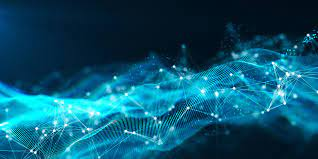

<hr style="border-width: 2px ; border-color: #143fe5">  

# [ 01 | INITIALISATION ] <a name='cell-init'></a>
[Back to top](#cell-toc)

## Import des librairies

In [221]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Imports
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

import os
import time
from datetime import timedelta

from pprint import pprint

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble     import RandomForestClassifier
from sklearn.svm          import SVC
from sklearn.tree         import DecisionTreeClassifier

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, \
                                    StratifiedShuffleSplit

# Metrics
from sklearn.metrics import make_scorer, \
                            accuracy_score, balanced_accuracy_score, \
                            f1_score, precision_score, recall_score

from joblib import dump, load

## Paramètres

In [222]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Paramètres
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ENV_GOOGLE_COLAB = True     # True or False 

INPUT_CSV_FILENAME = 'rains.csv'
SCALER_FILENAME    = 'scaler.joblib'

if ENV_GOOGLE_COLAB:
    GD_MOUNT_PATH = '/content/drive'
    PROJECT_ROOT_PATH = os.path.join(GD_MOUNT_PATH, 'MyDrive', 'projects', 'project_2_deploiement')
    #
    DATA_PATH   = os.path.join(PROJECT_ROOT_PATH, 'data')
    MODEL_PATH  = os.path.join(PROJECT_ROOT_PATH, 'models')
    SCALER_PATH = os.path.join(PROJECT_ROOT_PATH, 'scaler')
else:
    DATA_PATH   = os.path.abspath(os.path.join('..', '..', 'data'))
    MODEL_PATH  = os.path.abspath(os.path.join('..', '..', 'models'))
    SCALER_PATH = os.path.abspath(oc.path.join('..', '..', 'scaler'))
    

## Connexion au Google Drive

In [223]:
if ENV_GOOGLE_COLAB:
    print('Environment: GOOGLE COLAB')
    if not os.path.exists(GD_MOUNT_PATH):
        print('Mounting Google Drive for Google Colab...')
        from google.colab import drive
        drive.mount(GD_MOUNT_PATH)
    else:
        print(f'Google Drive already mounted in: "{GD_MOUNT_PATH}"')
else:
    print('Environment: LOCAL')

Environment: GOOGLE COLAB
Google Drive already mounted in: "/content/drive"


# [ 02 | DATA LOAD ] <a name='cell-load-data'></a>
[Back to top](#cell-toc)

**Loading data into a Pandas Dataframe**

In [224]:
# Chargement des données dans un DataFrame Pandas

data_brut = pd.read_csv(
        filepath_or_buffer = os.path.join(DATA_PATH, INPUT_CSV_FILENAME)
    ,   sep = ','
    ,   header = 0
)

**Normalizing column names**

In [225]:
# Rename all column names so that they only contain lower case letters
data_brut.columns = data_brut.columns.str.lower()

**Dataframe Info**

In [226]:
data_brut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25631 entries, 0 to 25630
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           25631 non-null  object 
 1   location       25631 non-null  object 
 2   mintemp        24781 non-null  float64
 3   maxtemp        24885 non-null  float64
 4   rainfall       24570 non-null  float64
 5   evaporation    16385 non-null  float64
 6   sunshine       16142 non-null  float64
 7   windgustdir    21009 non-null  object 
 8   windgustspeed  21011 non-null  float64
 9   winddir9am     23020 non-null  object 
 10  winddir3pm     23947 non-null  object 
 11  windspeed9am   25073 non-null  float64
 12  windspeed3pm   24389 non-null  float64
 13  humidity9am    24800 non-null  float64
 14  humidity3pm    24141 non-null  float64
 15  pressure9am    21854 non-null  float64
 16  pressure3pm    21852 non-null  float64
 17  cloud9am       16480 non-null  float64
 18  cloud3

**Data Overview**

In [227]:
# Displaying a few observations randomly choosen
data_brut.sample(10)

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow
12692,2016-08-10,Melbourne,9.6,15.3,0.0,4.0,7.2,NNW,52.0,NNW,NNW,22.0,33.0,61.0,46.0,1010.8,1008.7,1.0,7.0,11.3,14.9,No,Yes
6785,2008-12-07,Canberra,16.5,26.6,0.0,12.4,12.3,WNW,57.0,W,WNW,24.0,28.0,33.0,10.0,1007.6,1006.2,2.0,1.0,20.9,25.3,No,No
18785,2016-03-23,GoldCoast,20.0,28.1,0.0,NaN,NaN,ESE,33.0,SSE,SE,22.0,28.0,50.0,60.0,1017.3,1014.9,NaN,NaN,25.8,26.7,No,No
6975,2009-06-15,Canberra,0.7,12.6,0.2,1.6,5.6,NW,20.0,NaN,NW,0.0,13.0,100.0,50.0,1014.9,1012.6,8.0,2.0,3.6,12.3,No,No
19792,2009-12-30,Adelaide,22.2,39.5,0.0,NaN,13.6,SW,33.0,NE,SW,13.0,24.0,18.0,9.0,1015.7,1011.1,NaN,NaN,32.3,38.2,No,No
17945,2013-12-04,GoldCoast,16.5,27.4,0.0,NaN,NaN,NNE,41.0,NE,NNE,11.0,33.0,62.0,63.0,1012.7,1007.5,NaN,NaN,24.8,25.8,No,No
13847,2010-10-14,Brisbane,14.8,25.6,0.2,7.0,5.6,NNE,22.0,NNW,NE,4.0,9.0,62.0,66.0,1017.7,1013.6,5.0,7.0,22.5,23.2,No,No
13639,2010-03-20,Brisbane,17.2,28.4,0.0,8.0,3.1,ESE,37.0,SE,ESE,15.0,17.0,59.0,73.0,1021.7,1019.8,7.0,7.0,24.7,24.4,No,No
21148,2013-12-14,Adelaide,13.8,26.0,0.0,NaN,13.1,W,39.0,SSE,SW,15.0,20.0,52.0,41.0,1022.1,1019.5,NaN,NaN,17.4,23.0,No,No
7793,2011-10-11,Canberra,3.9,17.5,0.0,5.6,7.0,NaN,NaN,WNW,WNW,24.0,35.0,55.0,32.0,1010.8,1009.2,6.0,NaN,10.1,16.1,No,No


# [ 03 | DATA PREPROCESSING ] <a name='cell-preprocessing-data'></a>
[Back to top](#cell-toc)

In [228]:
# La variable suivante contiendra le nom des colonnes que nous jugerons comme supprimables car non utiles pour 
# la suite
unneededCols = set(
    [       'cloud3pm'      # +30% missing data
        ,   'cloud9am'      # +30% missing data
        ,   'evaporation'   # +30% missing data
        ,   'raintoday'     # Doublon avec la colonne rainfall
        ,   'sunshine'      # +30% missing data
    ]
)

## Library

In [229]:
def convert_date(
        dataframe
    ,   date_col_name = 'date'
    ,   inplace       = False
):
    if not inplace:        
        df = dataframe.copy()
    else:
        df = dataframe
        
    # Pour la colonne "date": on convertit son type en date
    df[date_col_name] = pd.to_datetime(
            df[date_col_name]
        ,   format = '%Y/%m/%d'
        ,   exact  = True
    )

    # On découpe la date en morceaux:
    df['year']  = df[date_col_name].dt.year
    df['month'] = df[date_col_name].dt.month
    df['day']   = df[date_col_name].dt.day
    
    # Removing column "date"
    df.drop(columns=['date'], inplace=True)    
    
    return df
    

    
def remove_unneeded_cols(
        dataframe
    ,   unneededCols
    ,   inplace = False
):
    print('You want to remove the following columns:')
    print(unneededCols)
    res = dataframe.drop(
            columns = unneededCols
        ,   inplace = inplace
    )
    if inplace == True:
        return dataframe
    return res



def replace_nan_for_numeric_cols(
    dataframe
):
    print('\nRemplacement des valeurs manquantes au sein des variables numériques...')
    
    # Identifying numerical variables
    numColNames = dataframe \
        .select_dtypes(include = np.number) \
        .drop(columns=['year','month','day'], inplace = False) \
        .columns.tolist()
    
    print(f'   [before]: missing value count: {dataframe[numColNames].isnull().sum().sum()}')

    # Calcul de la médiane pour chaque couple : { location ; month }
    aggFn  = 'median'
    cols = numColNames + ['location', 'month']
    df_agg = dataframe[cols] \
        .groupby(by=['location', 'month']) \
        .agg([aggFn])

    for col in numColNames:
        df = dataframe[(dataframe[col].isnull())]
        locations = df['location'].unique()
        months    = df['month'].unique()
        for location in locations:
            for month in months:
                replaceValue = df_agg.loc[(location,month),(col,aggFn)]
                if pd.isna(replaceValue):
                    dataframe.drop(
                            index   = df[(df['location'] == location)&(df['month'] == month)].index 
                        ,   inplace = True
                    )
                    continue
                idx = df[(df['location'] == location)&(df['month'] == month)].index
                dataframe.loc[idx, col]=replaceValue

    print(f'   [after]: missing value count: {dataframe[numColNames].isnull().sum().sum()}')

    
    
    
def replace_nan_for_categorical_cols(
    dataframe
):
    print('\nRemplacement des valeurs manquantes au sein des variables catégorielles...')
    
    # categorical variables
    catColNames = dataframe \
        .select_dtypes(include = 'object') \
        .drop(columns=['location'], inplace = False) \
        .columns.tolist()

    print(f'   [before]: missing value count: {dataframe[catColNames].isnull().sum().sum()}')    
    
    # Calcul du mode pour chaque couple : { location ; month }
    aggFn  = pd.Series.mode
    cols = catColNames + ['location', 'month']
    df_agg = dataframe[cols] \
        .groupby(by=['location', 'month']) \
        .agg([aggFn])

    for col in catColNames:
        df = dataframe[(dataframe[col].isnull())]
        locations = df['location'].unique()
        months    = df['month'].unique()
        for location in locations:
            for month in months:
                replaceValue = df_agg.loc[(location,month),(col,'mode')]
                if isinstance(replaceValue, np.ndarray):
                    replaceValue = replaceValue[0]
                if pd.isna(replaceValue):
                    dataframe.drop(
                            index   = df[(df['location'] == location)&(df['month'] == month)].index
                        ,   inplace = True
                    )
                    continue
                idx = df[(df['location'] == location)&(df['month'] == month)].index
                dataframe.loc[idx, col]=replaceValue

    print(f'   [after]: missing value count: {dataframe[catColNames].isnull().sum().sum()}')

    
    
    
def data_encoding(
        dataframe
    ,   unneededCols
):
    
    print('\nData Encoding...')
    
    # RainTomorrow 
    #     remplacement de:
    #        'No'  par 0 
    #        'Yes' par 1    
    print('\ncol: raintomorrow')
    print(f'[before]: value counts:')
    print(dataframe['raintomorrow'].value_counts())
    dataframe['raintomorrow'].replace(
            to_replace = {
                    'No': 0
                ,   'Yes': 1
            }
        ,   inplace = True
    )
    print(f'[after]: value counts:')
    print(dataframe['raintomorrow'].value_counts())
    
    # Encoding categorical variables
    #
    print('\nEncoding categorical variables...')
    catColNames = dataframe \
        .select_dtypes(exclude = np.number) \
        .columns.to_list()
    print('concerned columns: ', catColNames)
    # Encodage de chacune de ces variables catégorielles
    for colName in catColNames:
        print('Encoding variable: ', colName)
        dataframe = pd.merge(
                left        = dataframe
            ,   right       = pd.get_dummies(
                                      dataframe[colName]
                                  ,   prefix     = colName
                                  ,   prefix_sep = '_'
                              )
            ,   how         = 'inner'
            ,   left_index  = True
            ,   right_index = True 
            ,   suffixes    = ['_l', '_r']
            ,   validate    = 'one_to_one' 
        )
    # Les colonnes catégorielles d'origine peuvent désormais etre supprimées
    unneededCols.update(catColNames)
    
    return dataframe
    
    
    
    
def preprocessing(
        dataframe
    ,   unneededCols
):
    
    data = dataframe.copy()
    
    print('Traitement de la colonne "date" ...')
    beg_n = data.shape[1]
    data = convert_date(data, inplace = True)
    end_n  = data.shape[1]
    print(f'[ OK ]: nb columns evolution: {end_n - beg_n:+}')
    
    # Missing values
    #
    # concernant la TARGET
    print('\nSuppression de toutes les observations pour lesquelles le LABEL est manquant')
    beg_n = data.shape[0]
    data = data[data['raintomorrow'].notna()].copy()
    end_n = data.shape[0]
    print(f'OK - observations evolution: {end_n - beg_n}')
    #
    # concernant les variables numériques
    replace_nan_for_numeric_cols(data)
    #
    # concernant les variables catégorielles    
    replace_nan_for_categorical_cols(data)    
    
    # Data Encoding
    #
    data = data_encoding(data, unneededCols)
    
    print('\nRemoving unneeded columns...')
    beg_n = data.shape[1]    
    remove_unneeded_cols(data, unneededCols = unneededCols, inplace = True)
    end_n = data.shape[1]
    print(f'[ OK ]: nb columns evolution: {end_n - beg_n:+}')        
    
    return data




def displayCorrMatrix(
        df
    ,   maskUpperDiag = True
    ,   cmap          = None
    ,   figsize       = None
):

    # Exemple: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

    # Création de la matrice de corrélation
    corrM = df.corr()

    # Génération d'un masque pour le triangle supérieur de la mtrice (le masque servira à masquer la partie de la matrice
    # que l'on ne souhaite pas afficher)
    if maskUpperDiag:
        mask = np.triu(np.ones_like(corrM, dtype = bool))
    else:
        mask = None

    # Préparation de la figure matplotlib
    if figsize is not None:
        f, ax = plt.subplots(figsize = figsize)

    # Génération de la palette de couleurs
    if cmap is None:
        cmap = sns.color_palette('coolwarm', as_cmap = True)

    # Affichage de la représentation graphique de la matrice de corrélation
    sns.heatmap(
            corrM.apply(np.around, args = [2])
        ,   mask   = mask
        ,   cmap   = cmap
        ,   center = 0
        ,   square = True
        ,   linewidths = 1
        ,   cbar_kws = {"shrink": 0.5}
        ,   annot = True
    )
    
    plt.show()

## Applying Data Preprocessing

In [230]:
data_clean = preprocessing(data_brut, unneededCols)

Traitement de la colonne "date" ...
[ OK ]: nb columns evolution: +2

Suppression de toutes les observations pour lesquelles le LABEL est manquant
OK - observations evolution: -1062

Remplacement des valeurs manquantes au sein des variables numériques...
   [before]: missing value count: 51504
   [after]: missing value count: 0

Remplacement des valeurs manquantes au sein des variables catégorielles...
   [before]: missing value count: 2726
   [after]: missing value count: 0

Data Encoding...

col: raintomorrow
[before]: value counts:
No     12060
Yes     3484
Name: raintomorrow, dtype: int64
[after]: value counts:
0    12060
1     3484
Name: raintomorrow, dtype: int64

Encoding categorical variables...
concerned columns:  ['location', 'windgustdir', 'winddir9am', 'winddir3pm', 'raintoday']
Encoding variable:  location
Encoding variable:  windgustdir
Encoding variable:  winddir9am
Encoding variable:  winddir3pm
Encoding variable:  raintoday

Removing unneeded columns...
You want to rem

## Checking Data Preprocessing

**Missing Data**

In [231]:
nbNulls = data_clean.isnull().sum()

print(f'Detected missing values inside the dataframe: {nbNulls.sum()}')

Detected missing values inside the dataframe: 0


**Dataframe Info**

In [232]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15544 entries, 3039 to 25630
Data columns (total 71 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   mintemp             15544 non-null  float64
 1   maxtemp             15544 non-null  float64
 2   rainfall            15544 non-null  float64
 3   windgustspeed       15544 non-null  float64
 4   windspeed9am        15544 non-null  float64
 5   windspeed3pm        15544 non-null  float64
 6   humidity9am         15544 non-null  float64
 7   humidity3pm         15544 non-null  float64
 8   pressure9am         15544 non-null  float64
 9   pressure3pm         15544 non-null  float64
 10  temp9am             15544 non-null  float64
 11  temp3pm             15544 non-null  float64
 12  raintomorrow        15544 non-null  int64  
 13  year                15544 non-null  int64  
 14  month               15544 non-null  int64  
 15  day                 15544 non-null  int64  
 16  l

# [ 04 | MODELISATION ] <a name='cell-model'></a>
[Back to top](#cell-toc)

## Paramètres

In [233]:
MODELISATION_RANDOM_STATE = 590
NB_FOLDS                  = 3

## Library

In [234]:
def getStrElaTime(
        begTime
    ,   endTime = None
):
    if endTime is None:
        endTime = time.time()
    return str(timedelta(seconds = endTime - begTime))




def saveDF(
        dataframe
    ,   filename
):
    filepath = os.path.join(DATA_PATH, filename + '.csv')
    dataframe.to_csv(
            path_or_buf     = filepath
        ,   sep             = ','
        ,   header          = True
        ,   index           = True
        ,   index_label     = 'index'
        ,   mode            = 'w'
        ,   encoding        = 'utf-8'
        ,   compression     = 'infer'
    )
    return filepath

## Sélection du jeu de données

In [235]:
# Sélection du jeu de données
data = data_clean.copy()

**Contrôle des valeurs manquantes**

In [236]:
nanCnt = data.isnull().sum().max()
if (nanCnt == 0):
    print('Le dataframe ne contient aucune valeur manquante.')
else:
    print('ATTENTION:\nAu moins une variable contient des valeurs manquantes !')

Le dataframe ne contient aucune valeur manquante.


**Split dataset**

In [237]:
# Séparation de la target des variables explicatives
features = data.drop(columns = ['raintomorrow'], inplace = False)
labels  = data['raintomorrow']

# Split du jeu de données pour conserver un jeu de données d'évaluation
n_splits = 1
s = StratifiedShuffleSplit(
        n_splits     = n_splits
    ,   test_size    = 0.25
    ,   random_state = MODELISATION_RANDOM_STATE
)

for train_index, test_index in s.split(features, labels):
    train_features = features.loc[features.index.intersection(train_index),:]
    train_labels   = labels.loc[labels.index.intersection(train_index)]
    test_features  = features.loc[features.index.intersection(test_index),:]
    test_labels    = labels.loc[labels.index.intersection(test_index)]
    
# Affichage des dimensions
print('shape[train_features]: ', train_features.shape)
print('shape[train_labels]  : ', train_labels.shape)
print('shape[test_features] : ', test_features.shape)
print('shape[test_labels]   : ', test_labels.shape)

shape[train_features]:  (8770, 70)
shape[train_labels]  :  (8770,)
shape[test_features] :  (2928, 70)
shape[test_labels]   :  (2928,)


**Distribution des classes de la variable expliquée**

In [238]:
print('Distribution des classes de la target:')
print('TRAIN:')
print(train_labels.value_counts(normalize = True) * 100)
print('TEST:')
print(test_labels.value_counts(normalize = True) * 100)

Distribution des classes de la target:
TRAIN:
0    76.704675
1    23.295325
Name: raintomorrow, dtype: float64
TEST:
0    77.254098
1    22.745902
Name: raintomorrow, dtype: float64


## Dataframe min max pour l'API prédiction

In [239]:
# Détermination des valeurs maximales et minimales pour les features numériques.
# Puisque nous avons beaucoup de features, nous voulons être capables d'en générer 
# certaines de façon aléatoire.
# Pour ne pas mettre générer des valeurs aberrantes, nous allons nous reposer
# sur les valeurs min et max des features telles qu'elles étaient sur le jeu
# de données d'entrainement

numCols = [
        'mintemp'
    ,   'maxtemp'
    ,   'rainfall'
    ,   'windgustspeed'
    ,   'windspeed9am'
    ,   'windspeed3pm'
    ,   'humidity9am'
    ,   'humidity3pm'
    ,   'pressure9am'
    ,   'pressure3pm'
    ,   'temp9am'
    ,   'temp3pm'
]
numFeatures_min_max = pd.DataFrame(
    {       'min': train_features[numCols].min()
        ,   'max': train_features[numCols].max()
    }
)

# Affichage du contenu du dataframe "feat_num_min_max" pour contrôle
display(numFeatures_min_max)



,min,max
mintemp,-8.0,27.6
maxtemp,4.1,46.4
rainfall,0.0,182.6
windgustspeed,9.0,104.0
windspeed9am,0.0,65.0
windspeed3pm,0.0,61.0
humidity9am,15.0,100.0
humidity3pm,4.0,99.0
pressure9am,986.7,1040.6
pressure3pm,985.5,1037.9


In [240]:
# features_num_min_max
filepath = saveDF(numFeatures_min_max, 'numFeatures_min_max')
print(f'numFeatures_min_max dataframe saved in file: {filepath}')

numFeatures_min_max dataframe saved in file: /content/drive/MyDrive/projects/project_2_deploiement/data/numFeatures_min_max.csv


## Choix des modèles

In [241]:
models = {
        'logisticRegression'  : LogisticRegression()
    ,   'randomForest'        : RandomForestClassifier()
    ,   'decisionTree'        : DecisionTreeClassifier()
    ,   'supportVectorMachine': SVC()
}

## Grille de paramètres par modèle

In [242]:
gridParams = {
        # Logistic Regression
        'logisticRegression'  : {
                'penalty'     : ['none', 'l2']
            ,   'C'           : [0.001,0.01,0.1,1,10,100,1000]
            ,   'class_weight': [None, 'balanced']
            ,   'solver'      : ['newton-cg', 'lbfgs', 'saga']
            ,   'max_iter'    : [5000]
            ,   'random_state': [MODELISATION_RANDOM_STATE]
        }
    ,   'randomForest'        : {
                'n_estimators': [200, 500]
            ,   'max_features': ['auto', 'sqrt', 'log2']
            ,   'max_depth'   : [None, 4, 10, 30]
            ,   'criterion'   : ['gini', 'entropy']
            ,   'class_weight': ['balanced', 'balanced_subsample']
            ,   'bootstrap'   : [True, False]
            ,   'random_state': [MODELISATION_RANDOM_STATE]
        }
    ,   'decisionTree'        : {
                'criterion'   : ['gini', 'entropy']
            ,   'splitter'    : ['best', 'random']
            ,   'max_depth'   : [None, 4, 10, 30]
            ,   'max_features': ['auto', 'sqrt', 'log2']
            ,   'class_weight': ['balanced']
            ,   'random_state': [MODELISATION_RANDOM_STATE]
        }
    ,   'supportVectorMachine': {
                'C'           : [0.1, 1, 10, 100, 1000]
            ,   'kernel'      : ['rbf', 'poly']
            ,   'gamma'       : [0.1, 1, 10, 100]
            # ,   'degree'      : [1, 2, 3, 4, 5, 6]
            ,   'random_state': [MODELISATION_RANDOM_STATE]
        }
}

## Choix des métriques

In [243]:
# Nous traitons un problème de classification:
# il nous faut donc retenir uniquement des métriques relative à la classification.
# La métrique "accuracy" est celle qui est le plus souvent utilisée dans ce cas.
#
# Or, nous avons remarqué un déséquilibre au niveau des classes de la target.
# Pour parer à cela nous allons considérer d'autres métriques et celle qui sera utilisée pour juger de la performance
# du modèle sera la métrique: balanced_accuracy

scoreFns = {
        'accuracy'          : make_scorer(accuracy_score)
    ,   'balanced_accuracy' : make_scorer(balanced_accuracy_score)
    ,   'f1'                : make_scorer(f1_score)
    ,   'precision'         : make_scorer(precision_score)
    ,   'recall'            : make_scorer(recall_score)
}

## Instanciation des modèles par Cross Validation

In [244]:
# Data Standardization
#
scaler = StandardScaler().fit(train_features)

# Backing up the scaler
scaler_filepath = os.path.join(SCALER_PATH, SCALER_FILENAME)
dump(
        scaler
    ,   scaler_filepath
)
print(f'Scaler saved in file: {scaler_filepath}')

# Transforming TRAIN features
train_scaled_features = scaler.transform(train_features)
train_features = pd.DataFrame(
        data    = train_scaled_features
    ,   columns = train_features.columns
    ,   index   = train_features.index
)
train_scaled_features = None
# Transforming TEST data
test_scaled_features = scaler.transform(test_features)
test_features = pd.DataFrame(
        data    = test_scaled_features
    ,   columns = test_features.columns
    ,   index   = test_features.index
)
test_scaled_features = None

# Construction des folds pour la validation croisée
folds = StratifiedKFold(
        n_splits     = NB_FOLDS
    ,   shuffle      = True
    ,   random_state = MODELISATION_RANDOM_STATE
)

# Pour chacun des modèles à évaluer
for (modelName, model) in models.items():
    
    begTime = time.time()

    grid = RandomizedSearchCV(
            estimator           = model
        ,   param_distributions = gridParams[modelName]
        ,   n_iter              = 100
        ,   scoring             = 'balanced_accuracy'
        ,   n_jobs              = -1
        ,   refit               = True
        ,   cv                  = folds
        ,   random_state        = MODELISATION_RANDOM_STATE
        ,   verbose             = 1
    )
    
    grid.fit(train_features, train_labels)
    
    strElaTime = getStrElaTime(begTime = begTime)
    
    print(f'~~~~[ Results for model: {modelName} ]~~~~')
    print('')
    print(f'Best score: {grid.best_score_}')
    print('')
    print('Best parameters:')
    pprint(grid.best_params_)
    print('')
    #print('Grid scores:')
    #means = grid.cv_results_['mean_test_score']
    #stds  = grid.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    #    print('%0.3f (+/-%0.03f) for %r' % (mean, std * 2, params))
    #print('')
    print(f'Compute time: {strElaTime}')
    print('\n\n')
    
    
    # Saving best model
    modelFilename = modelName + '.joblib'    
    modelFilepath = os.path.join(MODEL_PATH, modelFilename)
    dump(grid, modelFilepath)
    print(f'{modelName} model saved in file: {modelFilepath}')

Scaler saved in file: /content/drive/MyDrive/projects/project_2_deploiement/scaler/scaler.joblib
Fitting 3 folds for each of 84 candidates, totalling 252 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 84 is smaller than n_iter=100. Running 84 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


~~~~[ Results for model: logisticRegression ]~~~~

Best score: 0.7490167942540479

Best parameters:
{'C': 0.01,
 'class_weight': 'balanced',
 'max_iter': 5000,
 'penalty': 'l2',
 'random_state': 590,
 'solver': 'newton-cg'}

Compute time: 0:01:01.714080



logisticRegression model saved in file: /content/drive/MyDrive/projects/project_2_deploiement/models/logisticRegression.joblib
Fitting 3 folds for each of 100 candidates, totalling 300 fits
~~~~[ Results for model: randomForest ]~~~~

Best score: 0.7457221813453384

Best parameters:
{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'n_estimators': 200,
 'random_state': 590}

Compute time: 0:17:15.882798



randomForest model saved in file: /content/drive/MyDrive/projects/project_2_deploiement/models/randomForest.joblib
Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 48 is smaller than n_iter=100. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


~~~~[ Results for model: decisionTree ]~~~~

Best score: 0.7080063652994556

Best parameters:
{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'log2',
 'random_state': 590,
 'splitter': 'best'}

Compute time: 0:00:03.005917



decisionTree model saved in file: /content/drive/MyDrive/projects/project_2_deploiement/models/decisionTree.joblib
Fitting 3 folds for each of 40 candidates, totalling 120 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 40 is smaller than n_iter=100. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


~~~~[ Results for model: supportVectorMachine ]~~~~

Best score: 0.6856670830634144

Best parameters:
{'C': 0.1, 'gamma': 0.1, 'kernel': 'poly', 'random_state': 590}

Compute time: 0:06:22.364305



supportVectorMachine model saved in file: /content/drive/MyDrive/projects/project_2_deploiement/models/supportVectorMachine.joblib


## Backing up dataframes

In [245]:
# Backing up Train dataframes
#
# train_features
filepath = saveDF(train_features, 'train_features')
print(f'train_features dataframe saved in file: {filepath}')
#
# train_labels
filepath = saveDF(train_labels, 'train_labels')
print(f'train_labels dataframe saved in file: {filepath}')
#
# test_features
filepath = saveDF(test_features, 'test_features')
print(f'test_features dataframe saved in file: {filepath}')
#
# test_labels
filepath = saveDF(test_labels, 'test_labels')
print(f'test_labels dataframe saved in file: {filepath}')
#
# features_num_min_max
filepath = saveDF(features_num_min_max, 'features_num_min_max')
print(f'features_num_min_max dataframe saved in file: {filepath}')



train_features dataframe saved in file: /content/drive/MyDrive/projects/project_2_deploiement/data/train_features.csv
train_labels dataframe saved in file: /content/drive/MyDrive/projects/project_2_deploiement/data/train_labels.csv
test_features dataframe saved in file: /content/drive/MyDrive/projects/project_2_deploiement/data/test_features.csv
test_labels dataframe saved in file: /content/drive/MyDrive/projects/project_2_deploiement/data/test_labels.csv
features_num_min_max dataframe saved in file: /content/drive/MyDrive/projects/project_2_deploiement/data/features_num_min_max.csv
